In [7]:
import bench_lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bench_plot_lib as plot_lib
import seaborn as sns


import importlib
importlib.reload(bench_lib)
importlib.reload(plot_lib)

GiB = 2**30

SYS_NAME = "cache_ext"
FIGURES_DIR = "figures/"
iops_select_fn = lambda r: r["jobs"][0]["read"]["iops"]
leveldb_throughput_avg_select_fn = lambda r: r["throughput_avg"]
leveldb_latency_p99_select_fn = lambda r: r["latency_p99"] / 10**3
leveldb_read_latency_p99_select_fn = lambda r: r["read_latency_p99"] / 10**3

def filter_cgroup_results(results, cgroup_name):
    return [r for r in results if r.config["cgroup_name"] == cgroup_name]

def filter_cache_ext_results(results):
    return filter_cgroup_results(results, bench_lib.DEFAULT_CACHE_EXT_CGROUP)

def add_config_field(results, key, value):
    for r in results:
        if key not in r.config:
            r.config[key] = value


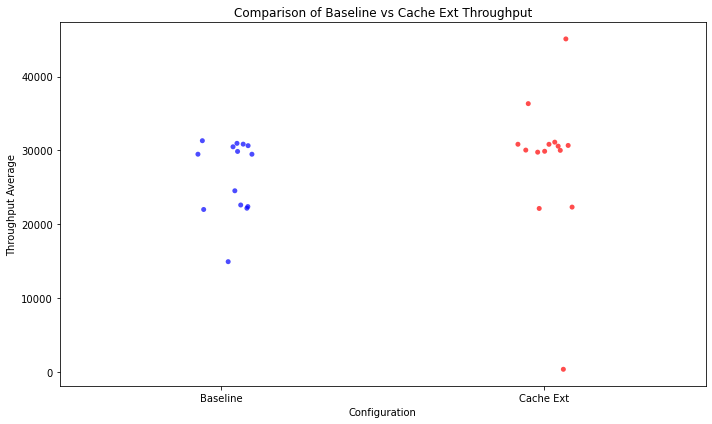

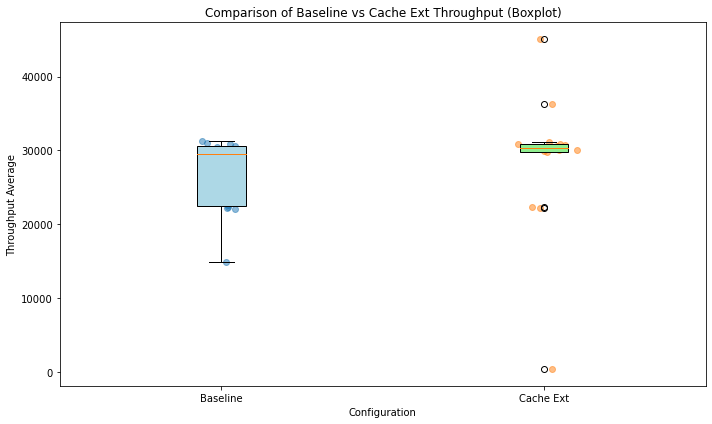

Baseline Throughput Average: 26549.80
Cache Ext Throughput Average: 28567.96
Diff 7.60%


In [26]:
io_trace_results = bench_lib.parse_results_file("io_trace_results_test_lru_vm5.json", bench_lib.BenchResults)

config_matches = [
    {
        "name": "iotrace_benchmark",
        "benchmark": "trace_cluster1_16TB_20240115_data-00052-of-00100"
    }
]

config_matches = bench_lib.add_config_option("cgroup_size", [15*GiB], config_matches)
config_matches = bench_lib.add_config_option("cgroup_name", [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP], config_matches)

baseline_config = config_matches[0]
cache_ext_config = config_matches[1]

throughput_avg_select_fn = lambda r: r.results["throughput_avg"]
read_throughput_avg_select_fn = lambda r: r.results["read_throughput_avg"]
insert_throughput_avg_select_fn = lambda r: r.results["insert_throughput_avg"]

baseline_results = map(insert_throughput_avg_select_fn, bench_lib.results_select(io_trace_results, baseline_config))
cache_ext_results = map(insert_throughput_avg_select_fn, bench_lib.results_select(io_trace_results, cache_ext_config))

# Convert to lists if they're not already
baseline_results = list(baseline_results)
cache_ext_results = list(cache_ext_results)

# Create a stripplot
plt.figure(figsize=(10, 6))

# Combine data and create labels
all_data = baseline_results + cache_ext_results
labels = ['Baseline'] * len(baseline_results) + ['Cache Ext'] * len(cache_ext_results)

# Create the stripplot
sns.stripplot(x=labels, y=all_data, jitter=True, size=5, palette={'Baseline': 'blue', 'Cache Ext': 'red'}, alpha=0.7)

plt.xlabel('Configuration')
plt.ylabel('Throughput Average')
plt.title('Comparison of Baseline vs Cache Ext Throughput')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Create a boxplot
plt.figure(figsize=(10, 6))

# Prepare data for boxplot
data = [baseline_results, cache_ext_results]
labels = ['Baseline', 'Cache Ext']

# Create the boxplot
box_plot = plt.boxplot(data, labels=labels, patch_artist=True)

# Customize boxplot colors
colors = ['lightblue', 'lightgreen']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

plt.xlabel('Configuration')
plt.ylabel('Throughput Average')
plt.title('Comparison of Baseline vs Cache Ext Throughput (Boxplot)')

# Add individual data points
for i, d in enumerate(data):
    y = d
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, alpha=0.5)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print average values for throughput
print("Baseline Throughput Average: {:.2f}".format(np.mean(baseline_results)))
print("Cache Ext Throughput Average: {:.2f}".format(np.mean(cache_ext_results)))
# Diff %
diff_pct = (np.mean(cache_ext_results) - np.mean(baseline_results)) / np.mean(baseline_results) * 100
print("Diff %.2f%%" % diff_pct)


## Filesearch Benchmark

In [7]:
baseline_filesearch_results = bench_lib.parse_results_file("baseline_filesearch_results.json", bench_lib.BenchResults)
baseline_mglru_filesearch_results = bench_lib.parse_results_file("baseline_mglru_filesearch_results.json", bench_lib.BenchResults)
cache_ext_filesearch_results = bench_lib.parse_results_file("filesearch_results.json", bench_lib.BenchResults)
cache_ext_filesearch_results = filter_cache_ext_results(cache_ext_filesearch_results)

add_config_field(baseline_filesearch_results, "mglru", False)
add_config_field(baseline_mglru_filesearch_results, "mglru", True)
add_config_field(cache_ext_filesearch_results, "mglru", False)

filesearch_results = baseline_filesearch_results + cache_ext_filesearch_results + baseline_mglru_filesearch_results

config_matches = [{"name": "filesearch_benchmark"}]
config_matches = bench_lib.add_config_option("cgroup_size", [1* GiB], config_matches)
config_matches = bench_lib.add_config_option("cgroup_name", [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP], config_matches)
# Add mglru option for baseline only
# Add mglru option for baseline only
baseline_matches = [cm for cm in config_matches if cm["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP]
cache_ext_matches = [cm for cm in config_matches if cm["cgroup_name"] == bench_lib.DEFAULT_CACHE_EXT_CGROUP]
baseline_matches = bench_lib.add_config_option("mglru", [False, True], baseline_matches)
config_matches = baseline_matches + cache_ext_matches

runtime_select_fn = lambda r: r["runtime_sec"]

plot_lib.bench_plot_groupped_results(
    config_matches,
    filesearch_results,
    y_label="Runtime (s)",
    show_measurements=False,
    colors=["salmon", "maroon", "limegreen"],
    bench_types=["filesearch"],
    result_select_fn=runtime_select_fn,
    bench_type_to_group={"filesearch": "File Search"},
    filename=FIGURES_DIR + "filesearch_results.pdf"
    )

{'name': 'filesearch_benchmark', 'cgroup_size': 1073741824, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'filesearch'}
[45.02097177505493]
{'name': 'filesearch_benchmark', 'cgroup_size': 1073741824, 'cgroup_name': 'baseline_test', 'mglru': True, 'benchmark': 'filesearch'}
[44.225725412368774]
{'name': 'filesearch_benchmark', 'cgroup_size': 1073741824, 'cgroup_name': 'cache_ext_test', 'benchmark': 'filesearch'}
[24.680588006973267]
[[45.02097177505493], [44.225725412368774], [24.680588006973267]]
['Baseline', 'MGLRU', 'cache_ext']
[-1.  0.  1.]
[-1.]
[0.]
[1.]


<Figure size 432x288 with 0 Axes>

## Generic Policies

In [8]:
# YCSB results

baseline_ycsb_results = bench_lib.parse_results_file("baseline_lfu_ycsb_results.json", bench_lib.BenchResults)
baseline_mglru_ycsb_results = bench_lib.parse_results_file("baseline_mglru_lfu_ycsb_results.json", bench_lib.BenchResults)
cache_ext_filesearch_results = bench_lib.parse_results_file("cache_ext_lfu_ycsb_results.json", bench_lib.BenchResults)
cache_ext_filesearch_results = filter_cache_ext_results(cache_ext_filesearch_results)

add_config_field(baseline_ycsb_results, "mglru", False)
add_config_field(baseline_mglru_ycsb_results, "mglru", True)
add_config_field(cache_ext_filesearch_results, "mglru", False)

ycsb_results = baseline_ycsb_results + cache_ext_filesearch_results + baseline_mglru_ycsb_results

config_matches = [
    {
        "name": "leveldb_benchmark",
    }
]
config_matches = bench_lib.add_config_option("cgroup_size", [10 * GiB], config_matches)
config_matches = bench_lib.add_config_option("cgroup_name", [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP], config_matches)


baseline_matches = [cm for cm in config_matches if cm["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP]
cache_ext_matches = [cm for cm in config_matches if cm["cgroup_name"] == bench_lib.DEFAULT_CACHE_EXT_CGROUP]
baseline_matches = bench_lib.add_config_option("mglru", [False, True], baseline_matches)
config_matches = baseline_matches + cache_ext_matches

plot_lib.leveldb_plot_ycsb_results(
    config_matches,
    ycsb_results,
    colors=["salmon", "maroon", "limegreen"],
    bench_types=["ycsb_a", "ycsb_b", "ycsb_c", "ycsb_f"],
    filename=FIGURES_DIR + "leveldb_ycsb_throughput.pdf",
    bar_width=1,
    show_measurements=False,
    result_select_fn=leveldb_throughput_avg_select_fn,
)

plot_lib.leveldb_plot_ycsb_results(
    config_matches,
    ycsb_results,
    colors=["salmon", "maroon", "limegreen"],
    bench_types=["ycsb_a", "ycsb_b", "ycsb_c", "ycsb_f"],
    filename=FIGURES_DIR + "leveldb_ycsb_latency.pdf",
    bar_width=1,
    result_select_fn=leveldb_latency_p99_select_fn,
    show_measurements=False,
    y_label="Latency (us)",
)

{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'ycsb_a'}
[15504.44, 15365.39, 15465.68, 15414.3, 15631.15, 15335.85, 15454.76, 15567.8, 15644.71]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'ycsb_b'}
[7744.95, 7736.37, 7721.33, 7734.07, 7749.02, 7730.83, 7740.6, 7644.77, 7743.65]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'ycsb_c'}
[5258.09, 5294.03, 5311.53, 5280.66, 5326.75, 5268.64, 5283.53, 5206.03, 5237.45]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'ycsb_f'}
[15571.08, 15539.48, 15474.31, 15482.09, 15371.16, 15554.56, 15396.06, 15505.86, 15365.19]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': True, 'benchmark': 'ycsb_a'}
[15363.82, 15

<Figure size 432x288 with 0 Axes>

## Application-Informed Policy

In [10]:
# Mixed GET-SCAN results
baseline_get_scan_results = bench_lib.parse_results_file("baseline_get_scan_results.json", bench_lib.BenchResults)
baseline_mglru_get_scan_results = bench_lib.parse_results_file("baseline_mglru_get_scan_results.json", bench_lib.BenchResults)
cache_ext_get_scan_results = bench_lib.parse_results_file("get_scan_ycsb_results_fadvise.json", bench_lib.BenchResults)
cache_ext_get_scan_results = filter_cache_ext_results(cache_ext_get_scan_results)

add_config_field(baseline_get_scan_results, "mglru", False)
add_config_field(baseline_mglru_get_scan_results, "mglru", True)
add_config_field(cache_ext_get_scan_results, "mglru", False)
get_scan_results = baseline_get_scan_results + cache_ext_get_scan_results + baseline_mglru_get_scan_results

config_matches = [
    {
        "name": "leveldb_benchmark",
    }
]

config_matches = bench_lib.add_config_option("cgroup_size", [10 * GiB], config_matches)
config_matches = bench_lib.add_config_option("cgroup_name", [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP], config_matches)

# Get the baseline config and generate two more:
# - One with "fadvise": "NOREUSE"
# - One with "fadvise": "DONTNEED"
# - One with "fadvise": "SEQUENTIAL"

baseline_matches = [cm for cm in config_matches if cm["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP]
cache_ext_matches = [cm for cm in config_matches if cm["cgroup_name"] == bench_lib.DEFAULT_CACHE_EXT_CGROUP]

baseline_matches = bench_lib.add_config_option("mglru", [False], baseline_matches)
baseline_matches = bench_lib.add_config_option("fadvise", ["", "NOREUSE", "DONTNEED", "SEQUENTIAL"], baseline_matches)
baseline_mglru_match = baseline_matches[0].copy()
baseline_mglru_match["mglru"] = True
baseline_matches.append(baseline_mglru_match)

config_matches = baseline_matches + cache_ext_matches


baseline_idx = 0
cache_ext_idx = -1

config_matches[baseline_idx]["iteration"] = 1
throughput_baseline = leveldb_throughput_avg_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[baseline_idx]).results)
latency_baseline = leveldb_read_latency_p99_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[baseline_idx]).results)
throughput_cache_ext = leveldb_throughput_avg_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[cache_ext_idx]).results)
latency_cache_ext = leveldb_read_latency_p99_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[cache_ext_idx]).results)

# Calculate improvement over baseline
throughput_improvement = throughput_cache_ext / throughput_baseline
latency_improvement = (latency_baseline - latency_cache_ext) / latency_baseline * 100
print(f"Throughput improvement: {throughput_improvement:.2f}x")
print(f"Latency reduction: {latency_improvement:.2f}%")

plot_lib.leveldb_plot_ycsb_results(
    config_matches,
    get_scan_results,
    result_select_fn=leveldb_throughput_avg_select_fn,
    colors=["salmon", "maroon", "lightgreen", "limegreen", "olivedrab", "darkolivegreen"],
    bench_types=["mixed_get_scan"],
    filename=FIGURES_DIR + "get_scan_throughput.pdf",
    bar_width=0.3,
    show_measurements=False,
    fontsize=16,
)

plot_lib.leveldb_plot_ycsb_results(
    config_matches,
    get_scan_results,
    result_select_fn=leveldb_read_latency_p99_select_fn,
    colors=["salmon", "maroon", "lightgreen", "limegreen", "olivedrab", "darkolivegreen"],
    bench_types=["mixed_get_scan"],
    filename=FIGURES_DIR + "get_scan_latency.pdf",
    y_label="Latency (us)",
    bar_width=0.3,
    show_measurements=False,
    fontsize=16,
)

Throughput improvement: 1.63x
Latency reduction: 85.11%
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'fadvise': '', 'iteration': 1, 'benchmark': 'mixed_get_scan'}
[1462.89]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'fadvise': 'NOREUSE', 'benchmark': 'mixed_get_scan'}
[1592.12]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'fadvise': 'DONTNEED', 'benchmark': 'mixed_get_scan'}
[1623.56]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'fadvise': 'SEQUENTIAL', 'benchmark': 'mixed_get_scan'}
[1558.93]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': True, 'fadvise': '', 'benchmark': 'mixed_get_scan'}
[1471.9]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'ben

<Figure size 432x288 with 0 Axes>

## Lines of Code - UX Evaluation

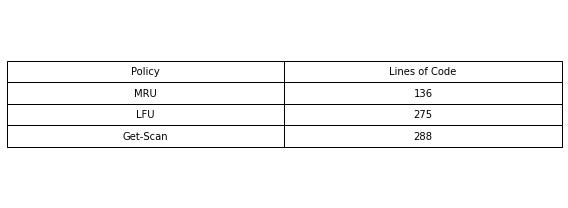

In [14]:
# Lines of code required for each policy

def c_file_is_loc(line: str):
    line = line.strip()
    if line.startswith("//") or line.startswith("/*") or line == "":
        return False
    return True

def c_file_count_loc(file_path: str):
    if not file_path.endswith(".c"):
        raise ValueError("File must be a C file")
    with open(file_path, "r") as f:
        lines = f.readlines()
    loc_count = 0
    for line in lines:
        if c_file_is_loc(line):
            loc_count += 1
    return loc_count

mru_loc_count = c_file_count_loc("page_cache_ext_mru.bpf.c")
lfu_loc_count = c_file_count_loc("page_cache_ext_sampling.bpf.c")
get_scan_loc_count = c_file_count_loc("page_cache_ext_get_scan.bpf.c")

# Put the LOC data in a table
table_data = [
    ["MRU", mru_loc_count],
    ["LFU", lfu_loc_count],
    ["Get-Scan", get_scan_loc_count],
]

# Create the table
fig = plt.figure(figsize=(8, 3))
table = plt.table(cellText=table_data,
                  colLabels=["Policy", "Lines of Code"],
                  cellLoc="center",
                  loc="center")

table.scale(1, 1.5)
plt.axis("off")
plt.tight_layout()
plt.show()

# Create a dataframe for the same table
df = pd.DataFrame(table_data, columns=["Policy", "Lines of Code"])
df.to_latex(FIGURES_DIR + "loc_table.tex", index=False,
            caption="Lines of code required for each policy presented.",
            label="tab:loc-per-policy")


## FIO Microbenchmark

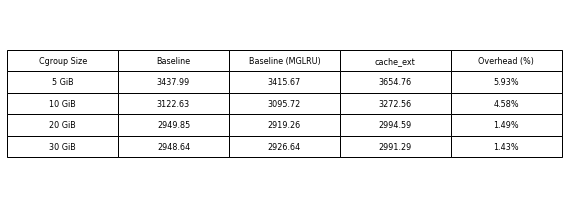

In [8]:
# Plot fio results

baseline_fio_results = bench_lib.parse_results_file("baseline_fio_results.json", bench_lib.BenchResults)
baseline_mglru_fio_results = bench_lib.parse_results_file("baseline_mglru_fio_results.json", bench_lib.BenchResults)
cache_ext_fio_results = bench_lib.parse_results_file("cache_ext_fio_results.json", bench_lib.BenchResults)

add_config_field(baseline_fio_results, "mglru", False)
add_config_field(baseline_mglru_fio_results, "mglru", True)
add_config_field(cache_ext_fio_results, "mglru", False)

cache_ext_fio_results = filter_cache_ext_results(cache_ext_fio_results)
fio_results = baseline_fio_results + cache_ext_fio_results + baseline_mglru_fio_results

cgroup_size = 30 * GiB
cgroup_sizes = [5 * GiB, 10 * GiB, 20 * GiB, 30 * GiB]

baseline_config_match = {
    "name": "fio_benchmark",
    "workload": "randread",
    "cgroup_name": "baseline_test",
    "mglru": False,
}

baseline_mglru_config_match = {
    "name": "fio_benchmark",
    "workload": "randread",
    "cgroup_name": "baseline_test",
    "mglru": True,
}

cache_ext_config_match = {
    "name": "fio_benchmark",
    "workload": "randread",
    "cgroup_name": "cache_ext_test",
    "mglru": False,
}

cpu_usage_per_iop_select_fn = lambda r: r["cpu_usage"] / iops_select_fn(r)

baseline_cpu_usage = {}
baseline_mglru_cpu_usage = {}
cache_ext_cpu_usage = {}
cpu_usage_diff = {}
for cgroup_size in cgroup_sizes:
    baseline_config_match["cgroup_size"] = cgroup_size
    baseline_cpu = plot_lib.results_select(fio_results, baseline_config_match, cpu_usage_per_iop_select_fn)
    baseline_cpu_usage[cgroup_size] = np.mean(baseline_cpu) * 10**6

    baseline_mglru_config_match["cgroup_size"] = cgroup_size
    baseline_mglru_cpu = plot_lib.results_select(fio_results, baseline_mglru_config_match, cpu_usage_per_iop_select_fn)
    baseline_mglru_cpu_usage[cgroup_size] = np.mean(baseline_mglru_cpu) * 10**6

    cache_ext_config_match["cgroup_size"] = cgroup_size
    cache_ext_cpu = plot_lib.results_select(fio_results, cache_ext_config_match, cpu_usage_per_iop_select_fn)
    cache_ext_cpu_usage[cgroup_size] = np.mean(cache_ext_cpu) * 10**6

    cpu_usage_diff[cgroup_size] = (cache_ext_cpu_usage[cgroup_size] - baseline_cpu_usage[cgroup_size]) / cache_ext_cpu_usage[cgroup_size] * 100

# print(baseline_cpu_usage)

# Put the CPU overhead data in a table
table_data = []

# Add a row for CPU usage
table_data.extend([
    ["5 GiB", f"{baseline_cpu_usage[5*GiB]:.2f}",   f"{baseline_mglru_cpu_usage[5*GiB]:.2f}", f"{cache_ext_cpu_usage[5*GiB]:.2f}", f"{cpu_usage_diff[5*GiB]:.2f}%"],
    ["10 GiB", f"{baseline_cpu_usage[10*GiB]:.2f}", f"{baseline_mglru_cpu_usage[10*GiB]:.2f}", f"{cache_ext_cpu_usage[10*GiB]:.2f}", f"{cpu_usage_diff[10*GiB]:.2f}%"],
    ["20 GiB", f"{baseline_cpu_usage[20*GiB]:.2f}", f"{baseline_mglru_cpu_usage[20*GiB]:.2f}", f"{cache_ext_cpu_usage[20*GiB]:.2f}", f"{cpu_usage_diff[20*GiB]:.2f}%"],
    ["30 GiB", f"{baseline_cpu_usage[30*GiB]:.2f}", f"{baseline_mglru_cpu_usage[30*GiB]:.2f}", f"{cache_ext_cpu_usage[30*GiB]:.2f}", f"{cpu_usage_diff[30*GiB]:.2f}%"],
])

# Create the table
fig = plt.figure(figsize=(8, 3))
table = plt.table(cellText=table_data,
                  colLabels=["Cgroup Size", "Baseline", "Baseline (MGLRU)", SYS_NAME, "Overhead (%)"],
                  cellLoc="center",
                  loc="center")
table.scale(1, 1.5)
plt.axis("off")
plt.tight_layout()
plt.show()

# Create a dataframe for the same table
df = pd.DataFrame(table_data, columns=["Cgroup Size", "Baseline", "Baseline (MGLRU)", SYS_NAME, "Overhead (%)"])
df.to_latex(FIGURES_DIR + "cpu_overhead_table.tex", index=False,
            caption="fio microbenchmark results to measure CPU overhead of \name per IO operation.",
            label="tab:eval-cpu-overhead",)


In [17]:
google_io_trace_results = bench_lib.parse_results_file("io_trace_results.json", bench_lib.BenchResults)

config_matches = [
    {
        "name": "iotrace_benchmark",
        "iteration": 1,
    }
]

config_matches = bench_lib.add_config_option("cgroup_size", [5 * GiB, 10 * GiB], config_matches)
config_matches = bench_lib.add_config_option("cgroup_name", [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP], config_matches)


plot_lib.bench_plot_groupped_results(
    config_matches,
    google_io_trace_results,
    colors=["salmon", "maroon", "limegreen", "olivedrab"],
    bench_types=["trace_cluster1_16TB_20240115_data-00000-of-00100"],
    filename="leveldb_ycsb_results.pdf",
    bar_width=0.3,
)

{'name': 'iotrace_benchmark', 'iteration': 1, 'cgroup_size': 5368709120, 'cgroup_name': 'baseline_test', 'benchmark': 'trace_cluster1_16TB_20240115_data-00000-of-00100'}
[432.71]
{'name': 'iotrace_benchmark', 'iteration': 1, 'cgroup_size': 5368709120, 'cgroup_name': 'cache_ext_test', 'benchmark': 'trace_cluster1_16TB_20240115_data-00000-of-00100'}
[914.49]
{'name': 'iotrace_benchmark', 'iteration': 1, 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'benchmark': 'trace_cluster1_16TB_20240115_data-00000-of-00100'}
[52.77]
{'name': 'iotrace_benchmark', 'iteration': 1, 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'benchmark': 'trace_cluster1_16TB_20240115_data-00000-of-00100'}
[46.1]
[[432.71], [914.49], [52.77], [46.1]]
['Baseline', 'cache_ext', 'Baseline', 'cache_ext']
[-0.45 -0.15  0.15  0.45]
[-0.45]
[-0.15]
[0.15]
[0.45]


<Figure size 432x288 with 0 Axes>